# import and Create Function

## import module

In [59]:
import requests
from datetime import datetime
from utils import getSchema, pd
from Calculator import Calculator as Calc
from PlotTools import plotKBar, transforDate
from copy import deepcopy

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [17]:
def get_minimum_tick(cost):
    
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5
    

def get_commission(cost, multiplier=1000, qty=1):

    commission = cost * multiplier * qty * (0.1425 / 100) 
    commission = 20 if commission < 20 else commission
    return commission

def get_Fee(cost, multiplier=1000, qty=1):
    return cost * multiplier * qty  * (0.3 / 100) 
    
def ReadDailyData(ticker:str, start_date:datetime, end_date:datetime):
#     url = 'http://127.0.0.1:8080/Api/Quote/TWSE/DAILY'
#     params = {
#         'Ticker':ticker,
#         'StartDate':start_date.strftime("%Y-%m-%d"),
#         'EndDate':end_date.strftime("%Y-%m-%d"),
#     }
#     res = requests.post(url, params=params)
#     js = res.json()
    schema = getSchema()
    table = schema['historicalPrice']
    datas = list(table.find({
        "Ticker":{"$eq":ticker},
        "Date":{"$gte":start_date.strftime("%Y-%m-%d"), "$lte":end_date.strftime("%Y-%m-%d")}
    }))
    return datas

In [62]:
data = ReadDailyData('1732', datetime(2004,10,15), datetime(2021,10,15))

In [73]:
df = pd.DataFrame(data)
del df['_id']
df = Calc.MA(df, [20])
df = Calc.EMA(df, [12])

last_bar = None
sig = pos = 0
entry = 0
exit = 0
max_ret = 0
moving_tp_threshold = 0.1
sl_ratio = .1
isInMoving = 0
entry_date = ""
exit_date = ""

record = []

for bar in df.itertuples():
    if not last_bar:
        last_bar = bar
    if bar.EMA12 and bar.MA20:
        if not pos and not sig:
            if bar.EMA12 >= bar.MA20 and last_bar.EMA12 < last_bar.MA20:
                sig = 1
        elif not pos and sig:
            pos, sig = sig, 0
            entry = bar.Close
            entry_date = bar.Date
        elif pos and not sig:
            exit = bar.Close
            tmp_ret = (exit/entry - 1)
            max_ret = max(max_ret, tmp_ret)
#             if tmp_ret >= moving_tp_threshold:
#                 isInMoving = 1
#             if isInMoving:
#                 if tmp_ret <= max_ret - 0.05:
#                     sig = -1
#             if tmp_ret <= -sl_ratio:
#                 sig = -1
            if bar.EMA12 <= bar.MA20 and last_bar.EMA12 > last_bar.MA20:
                sig = -1
            
        elif pos and sig:
            exit = bar.Close
            exit_date = bar.Date
            pnl = (exit - entry) * pos * 1000
            commission = int(get_commission(entry))
            commission += int(get_commission(exit))
            fee = int(get_Fee(exit if pos > 0 else entry))
            cost = commission + fee
            net_pnl = int(pnl - cost)
            rec = {
                "EntryDate":entry_date,
                "ExitDate":exit_date,
                "HoldingDuration":(pd.to_datetime(exit_date)-pd.to_datetime(entry_date)).days,
                "Entry":entry,
                "Exit":exit,
                "PnL":pnl,
                "Commission":commission,
                "Fee":fee,
                "TotalCost":cost,
                "NetPnL":net_pnl
            }
            print(rec, '\n')
            record.append(rec)
            sig = pos = 0
            entry = exit = 0
            entry_date = ""
            exit_date = ""
    last_bar = bar
    
    

{'EntryDate': '2004-11-26', 'ExitDate': '2004-12-13', 'HoldingDuration': 17, 'Entry': 8.0, 'Exit': 7.75, 'PnL': -250.0, 'Commission': 40, 'Fee': 23, 'TotalCost': 63, 'NetPnL': -313} 

{'EntryDate': '2004-12-28', 'ExitDate': '2005-01-24', 'HoldingDuration': 27, 'Entry': 7.85, 'Exit': 8.85, 'PnL': 1000.0, 'Commission': 40, 'Fee': 26, 'TotalCost': 66, 'NetPnL': 934} 

{'EntryDate': '2005-02-14', 'ExitDate': '2005-03-03', 'HoldingDuration': 17, 'Entry': 9.3, 'Exit': 9.1, 'PnL': -200.00000000000108, 'Commission': 40, 'Fee': 27, 'TotalCost': 67, 'NetPnL': -267} 

{'EntryDate': '2005-04-04', 'ExitDate': '2005-04-13', 'HoldingDuration': 9, 'Entry': 8.65, 'Exit': 8.51, 'PnL': -140.00000000000057, 'Commission': 40, 'Fee': 25, 'TotalCost': 65, 'NetPnL': -205} 

{'EntryDate': '2005-05-13', 'ExitDate': '2005-07-05', 'HoldingDuration': 53, 'Entry': 8.0, 'Exit': 8.35, 'PnL': 349.99999999999966, 'Commission': 40, 'Fee': 25, 'TotalCost': 65, 'NetPnL': 284} 

{'EntryDate': '2005-08-01', 'ExitDate': '200

In [74]:
result = pd.DataFrame(record)

In [75]:
result

,EntryDate,ExitDate,HoldingDuration,Entry,Exit,PnL,Commission,Fee,TotalCost,NetPnL
0,2004-11-26,2004-12-13,17,8.00,7.75,-250.0,40,23,63,-313
1,2004-12-28,2005-01-24,27,7.85,8.85,1000.0,40,26,66,934
2,2005-02-14,2005-03-03,17,9.30,9.10,-200.0,40,27,67,-267
3,2005-04-04,2005-04-13,9,8.65,8.51,-140.0,40,25,65,-205
4,2005-05-13,2005-07-05,53,8.00,8.35,350.0,40,25,65,284
...,...,...,...,...,...,...,...,...,...,...
108,2020-10-30,2020-11-19,20,22.10,21.60,-500.0,61,64,125,-625
109,2020-12-24,2021-02-19,57,23.15,26.10,2950.0,69,78,147,2803
110,2021-04-06,2021-04-19,13,25.80,25.10,-700.0,71,75,146,-845
111,2021-04-22,2021-06-04,43,26.40,39.80,13400.0,93,119,212,13187


<AxesSubplot:>

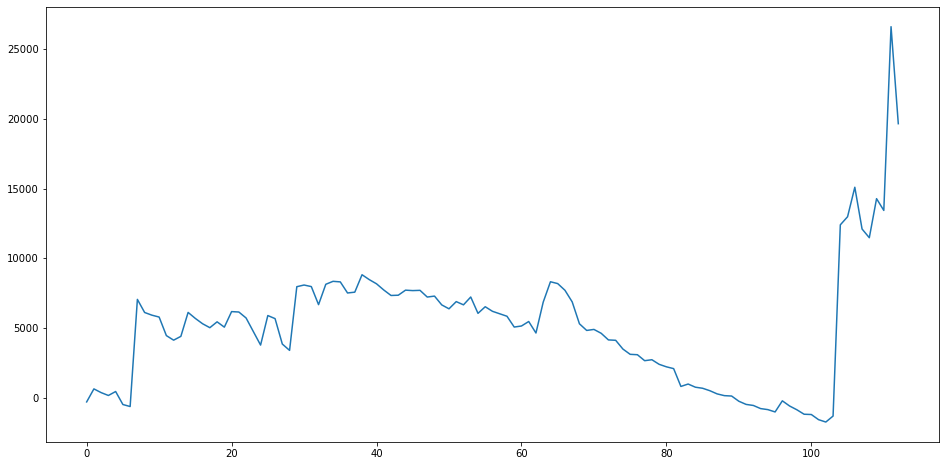

In [76]:
result.NetPnL.cumsum().plot(figsize=(16,8))

In [67]:
def PlotMACross(df):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.3, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])
    
    fig.add_trace(go.Candlestick(x=df.Date,
                    open=df.Open,
                    high=df.High,
                    low=df.Low,
                    close=df.Close), row=1,col=1)
    
    fig.add_trace(
        go.Scatter(
            x=df.Date,
            y=df.EMA12,
            name="EMA12",
        ), row=1,col=1)#,secondary_y=True,)
    fig.add_trace(
        go.Scatter(
            x=df.Date,
            y=df.MA20,
            name="MA20",
        ), row=1,col=1)#,secondary_y=True,)
#     fig.add_trace(go.Bar(x=bar_df.time, y=bar_df.volume, showlegend=False), row=2, col=1)
    
    fig.show()

In [68]:
PlotMACross(df)
# plt_df = deepcopy(df)
# plt_df.Date = plt_df.Date.apply(transforDate)

# ax = plt_df[['EMA12', "Date"]].set_index("Date").plot(figsize=(16,8))
# plotKBar(ax,df)
# df.EMA12.Plot